## 4. 3번의 상권별 특성 파악
* 업종별 특성 파악
* 매출, 성별, 연령대 집중도 등

4에서 사용되는 테이블
* 유동인구 많은 상위 지역(resident_area, working_area)별로 업종 파악: service_Category
* 유동인구 많은 상위 지역의 매출, 성별, 연령대 집중도: Sales_Sex, Sales_Age, Floating_Population

## 4.1. 업종별 특성 파악

### DB에서 데이터 가져오기

In [32]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query = """
-- 상권별 상주+직장 인구 합계
WITH pop_summary AS (
    SELECT
        year_quarter,
        commercial_area_code,
        SUM(population) AS total_population,
        pop_type
    FROM Population_GA
    GROUP BY year_quarter, commercial_area_code, pop_type
)
SELECT
    ca.name,
    sc.commercial_area_code,
    ps.pop_type,
    sc.service_category_code,
    sca.name "service_category_name",
    sc.shop_count,
    sc.similar_shop_count,
    ps.total_population
FROM Shop_Count sc
JOIN pop_summary ps
    ON sc.year_quarter = ps.year_quarter
    AND sc.commercial_area_code = ps.commercial_area_code
JOIN Commercial_Area ca
    ON ca.code = sc.commercial_area_code
JOIN Service_Category sca
    ON sca.code = sc.service_category_code;
"""

df = pd.read_sql(query, remote)

remote.close()

df.tail()

/var/folders/x1/3x1wk6hx6g3_dv91vx02k_dm0000gn/T/ipykernel_27962/2317859657.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,name,commercial_area_code,pop_type,service_category_code,service_category_name,shop_count,similar_shop_count,total_population
611057,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300024,운동/경기용품,5,5,894.0
611058,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300027,섬유제품,2,2,894.0
611059,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300029,애완동물,1,1,894.0
611060,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300035,인테리어,2,2,894.0
611061,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300043,전자상거래업,4,4,894.0


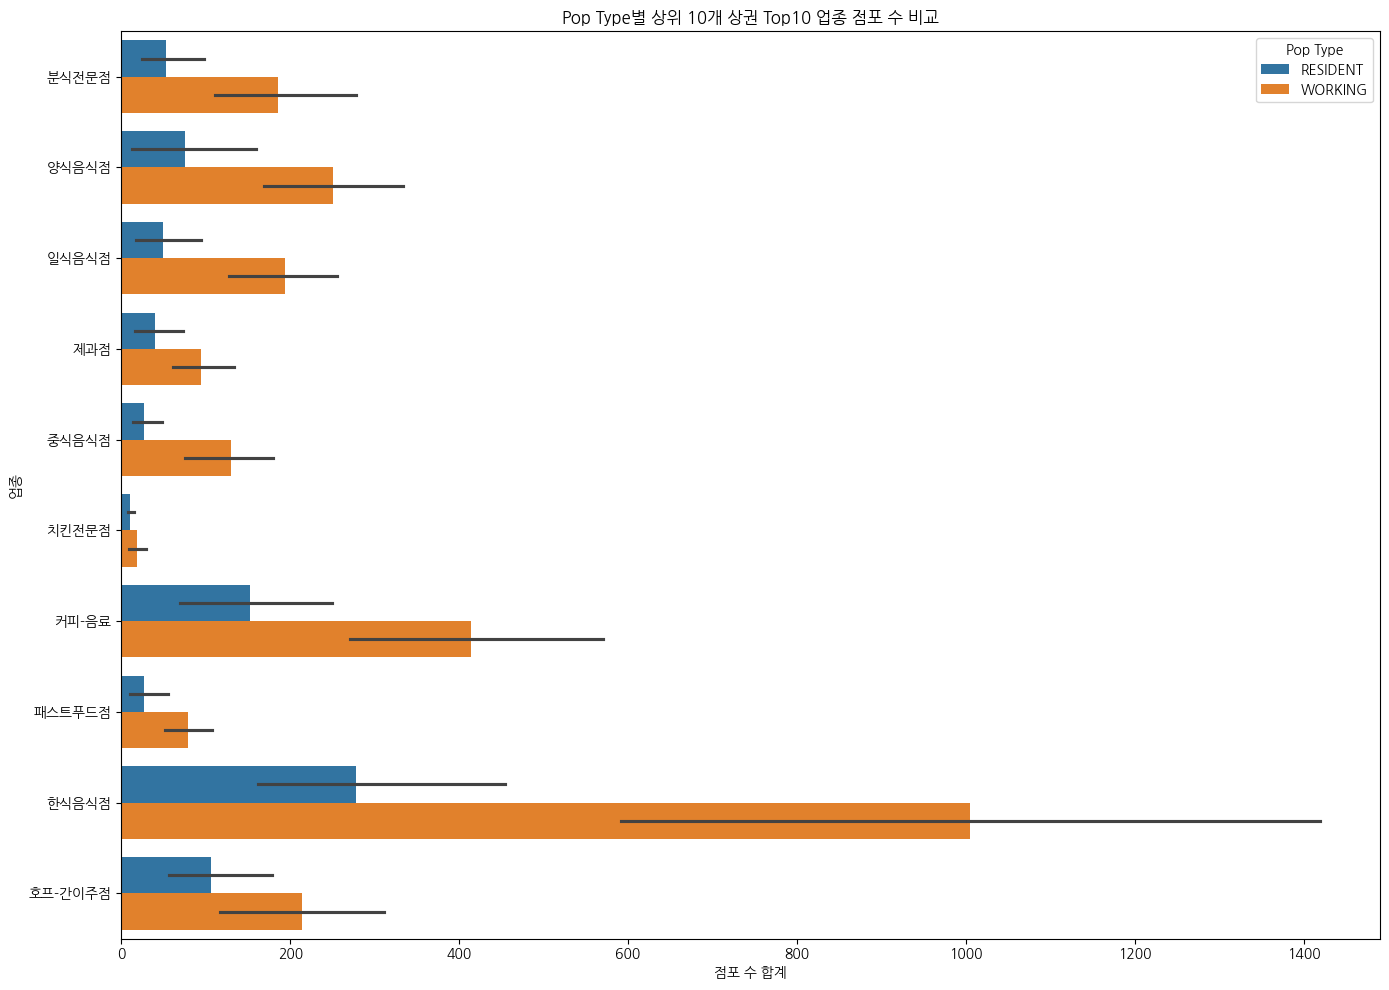

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

resident_top10 = [
    '화곡역 4번','까치산역 4번','망리단길','까치산역 1번','관악구 중앙길',
    '신림역 5번(신림동주민센터, 신림동별빛거리)','잠실 관광특구','선유도역 1번',
    '응암역 3번','길동주민센터(강동도서관)'
]
working_top10 = [
    '명동 남대문 북창동 다동 무교동 관광특구','여의도역(여의도)','잠실 관광특구',
    '삼성역','강남 마이스 관광특구','가산디지털단지','매봉역','잠실역','포스코사거리','강남역'
]

categories = [
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
]

df_filtered = df[
    ((df['pop_type']=='RESIDENT') & (df['name'].isin(resident_top10)) |
     (df['pop_type']=='WORKING') & (df['name'].isin(working_top10)))
    & df['service_category_name'].isin(categories)
]

agg_df = df_filtered.groupby(['pop_type','name','service_category_name']).agg(
    total_shop_count=('shop_count','sum')
).reset_index()


palette = {'RESIDENT':'#1f77b4', 'WORKING':'#ff7f0e'}
plt.figure(figsize=(14, 10))
sns.barplot(
    data=agg_df,
    x='total_shop_count',
    y='service_category_name',
    hue='pop_type',
    palette=palette
)
plt.title('Pop Type별 상위 10개 상권 Top10 업종 점포 수 비교')
plt.xlabel('점포 수 합계')
plt.ylabel('업종')
plt.legend(title='Pop Type')
plt.tight_layout()
plt.show()

### 결론
인구별(상주인구/직장인구) 매출 탑10 매장들은 한식 음식점이 많았다
유동인구는 데이터 매핑을 해도 유의미한 결과가 안 나와서 (숫자 그대로가 아니라 지수를 이용해야 함) 건너뜀

## 4.2. 매출/연령/성별 파악

###  DB에서 데이터 가져오기

In [ ]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query_day = """
SELECT
    sc.name AS category_name,
    sd.week,
    SUM(sd.sales) AS total_sales
FROM Shop_Count s
JOIN Service_Category sc
    ON s.service_category_code = sc.code
JOIN Sales_Day sd
    ON s.id = sd.store_id
WHERE sc.name IN (
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
)
GROUP BY sc.name, sd.week
ORDER BY sc.name, sd.week;

"""

query_sex= """
SELECT
    sc.name AS category_name,
    ss.sex,
    SUM(ss.sales) AS total_sales
FROM Shop_Count s
JOIN Service_Category sc
    ON s.service_category_code = sc.code
JOIN Sales_Sex ss
    ON s.id = ss.store_id
WHERE sc.name IN (
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
)
GROUP BY sc.name, ss.sex
ORDER BY sc.name, ss.sex;
"""

query_time="""
SELECT
    sc.name AS category_name,
    st.time,
    SUM(st.sales) AS total_sales
FROM Shop_Count s
JOIN Service_Category sc
    ON s.service_category_code = sc.code
JOIN Sales_Time st
    ON s.id = st.store_id
WHERE sc.name IN (
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
)
GROUP BY sc.name, st.time
ORDER BY sc.name, st.time;
"""

sales_day_df = pd.read_sql(query_day, remote)
sales_sex_df = pd.read_sql(query_sex, remote)
sales_time_df = pd.read_sql(query_time, remote)

remote.close()

print(sales_day_df.head())
print(sales_sex_df.head())
print(sales_time_df.head())


/tmp/ipykernel_9848/3026738714.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_day_df = pd.read_sql(query_day, remote)
/tmp/ipykernel_9848/3026738714.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_sex_df = pd.read_sql(query_sex, remote)
/tmp/ipykernel_9848/3026738714.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_time_df = pd.read_sql(query_time, remote)


  category_name       week   total_sales
0         분식전문점     MONDAY  1.613118e+11
1         분식전문점    TUESDAY  1.734468e+11
2         분식전문점  WEDNESDAY  1.734162e+11
3         분식전문점   THURSDAY  1.764660e+11
4         분식전문점     FRIDAY  1.869777e+11
  category_name     sex   total_sales
0         분식전문점    MALE  5.114427e+11
1         분식전문점  FEMALE  5.316015e+11
2         양식음식점    MALE  5.789689e+11
3         양식음식점  FEMALE  5.592079e+11
4         일식음식점    MALE  4.567671e+11
  category_name   time   total_sales
0         분식전문점  00-06  2.379050e+10
1         분식전문점  06-11  1.013353e+11
2         분식전문점  11-14  3.933612e+11
3         분식전문점  14-17  1.980792e+11
4         분식전문점  17-21  3.647725e+11


In [25]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query = """
SELECT 
    ts.store_id,
    ts.commercial_area_name,
    ts.service_category_code,
    ts.total_sales,
    
    sex.sex AS gender,
    sex.sales AS sales_by_gender,
    
    age.age AS age_band,
    age.sales AS sales_by_age,
    
    sd.week AS week_day,
    sd.sales AS sales_by_weekday,
    
    st.time AS time_slot,
    st.sales AS sales_by_time

FROM
(
    SELECT 
        sc.id AS store_id,
        ca.name AS commercial_area_name,
        sc.service_category_code,
        SUM(st.sales) AS total_sales
    FROM Shop_Count sc
    JOIN Sales_Time st ON sc.id = st.store_id
    JOIN Commercial_Area ca ON sc.commercial_area_code = ca.code
    GROUP BY sc.id, ca.name, sc.service_category_code
    ORDER BY total_sales DESC
    LIMIT 20
) ts
LEFT JOIN Sales_Sex sex ON ts.store_id = sex.store_id
LEFT JOIN Sales_Age age ON ts.store_id = age.store_id
LEFT JOIN Sales_Day sd ON ts.store_id = sd.store_id
LEFT JOIN Sales_Time st ON ts.store_id = st.store_id
ORDER BY ts.total_sales DESC, ts.store_id;
"""

df = pd.read_sql(query, remote)

remote.close()

df.head()

/var/folders/x1/3x1wk6hx6g3_dv91vx02k_dm0000gn/T/ipykernel_27962/1473939832.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,store_id,commercial_area_name,service_category_code,total_sales,gender,sales_by_gender,age_band,sales_by_age,week_day,sales_by_weekday,time_slot,sales_by_time
0,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,00-06,30297569176
1,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,06-11,195120243141
2,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,11-14,256704315137
3,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,14-17,275154245000
4,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,17-21,365472334060


### 시각화

In [3]:

print(sales_day_df.head())
print(sales_sex_df.head())
print(sales_time_df.head())

  category_name       week   total_sales
0         분식전문점     MONDAY  1.613118e+11
1         분식전문점    TUESDAY  1.734468e+11
2         분식전문점  WEDNESDAY  1.734162e+11
3         분식전문점   THURSDAY  1.764660e+11
4         분식전문점     FRIDAY  1.869777e+11
  category_name     sex   total_sales
0         분식전문점    MALE  5.114427e+11
1         분식전문점  FEMALE  5.316015e+11
2         양식음식점    MALE  5.789689e+11
3         양식음식점  FEMALE  5.592079e+11
4         일식음식점    MALE  4.567671e+11
  category_name   time   total_sales
0         분식전문점  00-06  2.379050e+10
1         분식전문점  06-11  1.013353e+11
2         분식전문점  11-14  3.933612e+11
3         분식전문점  14-17  1.980792e+11
4         분식전문점  17-21  3.647725e+11


In [11]:
import pandas as pd
import plotly.express as px

# category_name을 문자열로 변환
sales_day_df['category_name'] = sales_day_df['category_name'].astype(str)

# 상위 5% 이상 매출 제거
threshold = sales_day_df['total_sales'].quantile(0.95)
filtered_df = sales_day_df[sales_day_df['total_sales'] <= threshold]

# Plotly로 요일별/카테고리별 매출 그래프
fig = px.bar(
    filtered_df,
    x='week',
    y='total_sales',
    color='category_name',
    labels={
        'week': '요일',
        'total_sales': '매출액',
        'category_name': '카테고리'
    },
    title='요식업 카테고리별 요일별 매출 합계 (상위 5% 제외)',
    barmode='group'
)

# 범례 위치 조정
fig.update_layout(
    legend=dict(title='카테고리', x=1.05, y=1)
)

fig.show()



In [24]:
import plotly.express as px

fig = px.bar(
    sales_day_df,
    x='week',
    y='total_sales',
    color='category_name',
    labels={
        'week': '요일',
        'total_sales': '매출액',
        'category_name': '카테고리'
    },
    title='외식업 카테고리별 요일별 매출 합계 (로그 스케일)',
    barmode='group'
)

fig.update_yaxes(type='log')  # 로그 스케일 적용
fig.update_layout(legend=dict(title='카테고리', x=1.05, y=1))
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# category_name을 문자열로 변환
sales_day_df['category_name'] = sales_day_df['category_name'].astype(str)

# Plotly로 꺾은선 그래프 생성
fig = px.line(
    sales_day_df,
    x='week',
    y='total_sales',
    color='category_name',
    markers=True,
    labels={
        'week': '요일',
        'total_sales': '매출액',
        'category_name': '카테고리'
    },
    title='외식업 카테고리별 요일별 매출 (로그 스케일)'
)

fig.update_xaxes(
    type='category',
    showgrid=True,
    gridcolor='lightgray'
)

# y축 로그 스케일 + 그리드 표시
fig.update_yaxes(
    type='log',
    showgrid=True,
    gridcolor='lightgray'
)

# 라인 모드 적용
fig.update_traces(mode='lines+markers')

fig.update_layout(
    legend=dict(title='카테고리', x=1.05, y=1),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# 범례 위치
fig.update_layout(legend=dict(title='카테고리', x=1.05, y=1))

fig.show()



In [ ]:
import pandas as pd
import plotly.express as px

sales_sex_df['category_name'] = sales_sex_df['category_name'].astype(str)

fig = px.line(
    sales_sex_df,
    x='sex',
    y='total_sales',
    color='category_name',
    markers=True,     
    labels={
        'sex': '성별',
        'total_sales': '매출액',
        'category_name': '카테고리'
    },
    title='요식업 카테고리별 성별 매출 합계 (로그스케일 적용)',
)


fig.update_xaxes(
    type='category',
    showgrid=True,
    gridcolor='lightgray'
)

fig.update_yaxes(
    type='log',
    showgrid=True,
    gridcolor='lightgray'
)

fig.update_traces(mode='lines+markers')

fig.update_layout(
    legend=dict(title='카테고리', x=1.05, y=1),
    plot_bgcolor='white',
    paper_bgcolor='white'
)


fig.update_layout(legend=dict(title='카테고리', x=1.05, y=1))

fig.show()


In [ ]:
import plotly.express as px

fig = px.line(
    sales_time_df,
    x='time',
    y='total_sales',
    color='category_name',
    title='요식업 카테고리별 시간별 매출 합계',
    markers=True
)
fig.update_xaxes(
    type='category',
    showgrid=True,
    gridcolor='lightgray'
)

fig.update_yaxes(
    type='log',
    showgrid=True,
    gridcolor='lightgray'
)

fig.update_traces(mode='lines+markers')

fig.update_layout(
    legend=dict(title='카테고리', x=1.05, y=1),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# 범례 위치
fig.update_layout(legend=dict(title='카테고리', x=1.05, y=1))

fig.show()




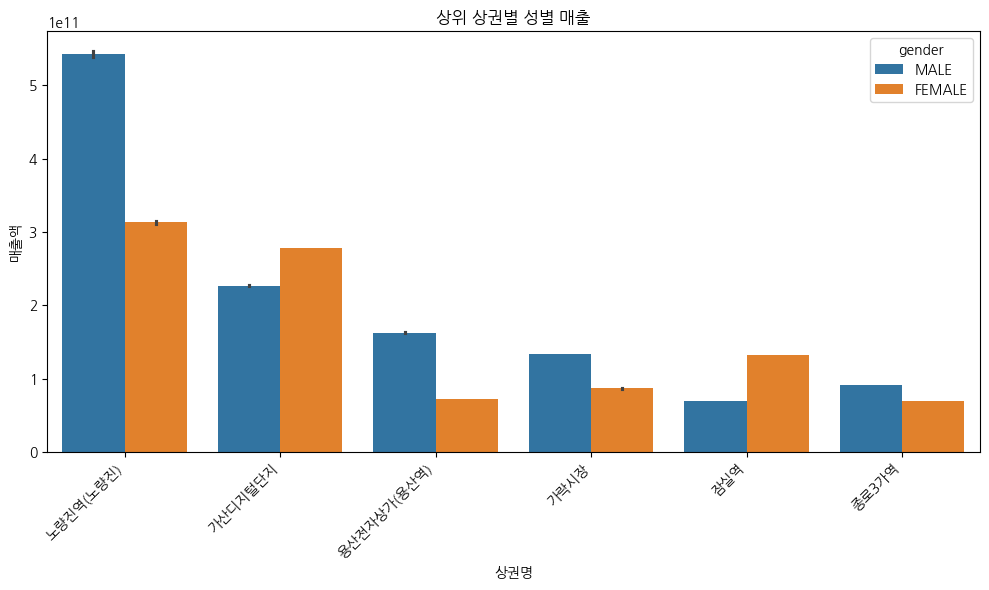

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 1. 성별 매출 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='commercial_area_name', y='sales_by_gender', hue='gender')
plt.title('상위 상권별 성별 매출')
plt.xticks(rotation=45, ha='right')
plt.ylabel('매출액')
plt.xlabel('상권명')
plt.tight_layout()
plt.show()


## 카테고리별 매출 탑인 상권

### DB에서 데이터 가져오기

In [ ]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query = """
SELECT
    ca.code AS commercial_area_code,
    ca.name AS commercial_area_name,
    sc.name AS service_category_name,
    SUM(sd.sales) AS total_sales
FROM
    Shop_Count sh
JOIN Service_Category sc
    ON sh.service_category_code = sc.code
JOIN Commercial_Area ca
    ON sh.commercial_area_code = ca.code
JOIN Sales_Daytype sd
    ON sd.store_id = sh.id
WHERE
    sc.name IN (
        '한식음식점', '중식음식점', '일식음식점', '양식음식점',
        '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
        '호프-간이주점', '커피-음료'
    )
GROUP BY
    ca.code, ca.name, sc.name
ORDER BY
    total_sales DESC;
"""

df = pd.read_sql(query, remote)

remote.close()

df.tail()

/tmp/ipykernel_13254/325509549.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,commercial_area_code,commercial_area_name,service_category_name,total_sales
7029,3130092,청량리농수산물시장,분식전문점,113208.0
7030,3110519,서대문구보건소별관,분식전문점,97577.0
7031,3130070,뚝섬역상점가,일식음식점,90525.0
7032,3130135,수유중앙골목시장(수유중앙시장),제과점,84610.0
7033,3110264,면목역 2번,커피-음료,19811.0


### 시각화

/tmp/ipykernel_13254/74015187.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('service_category_name', group_keys=False).apply(lambda x: x.nlargest(top_n, 'total_sales'))


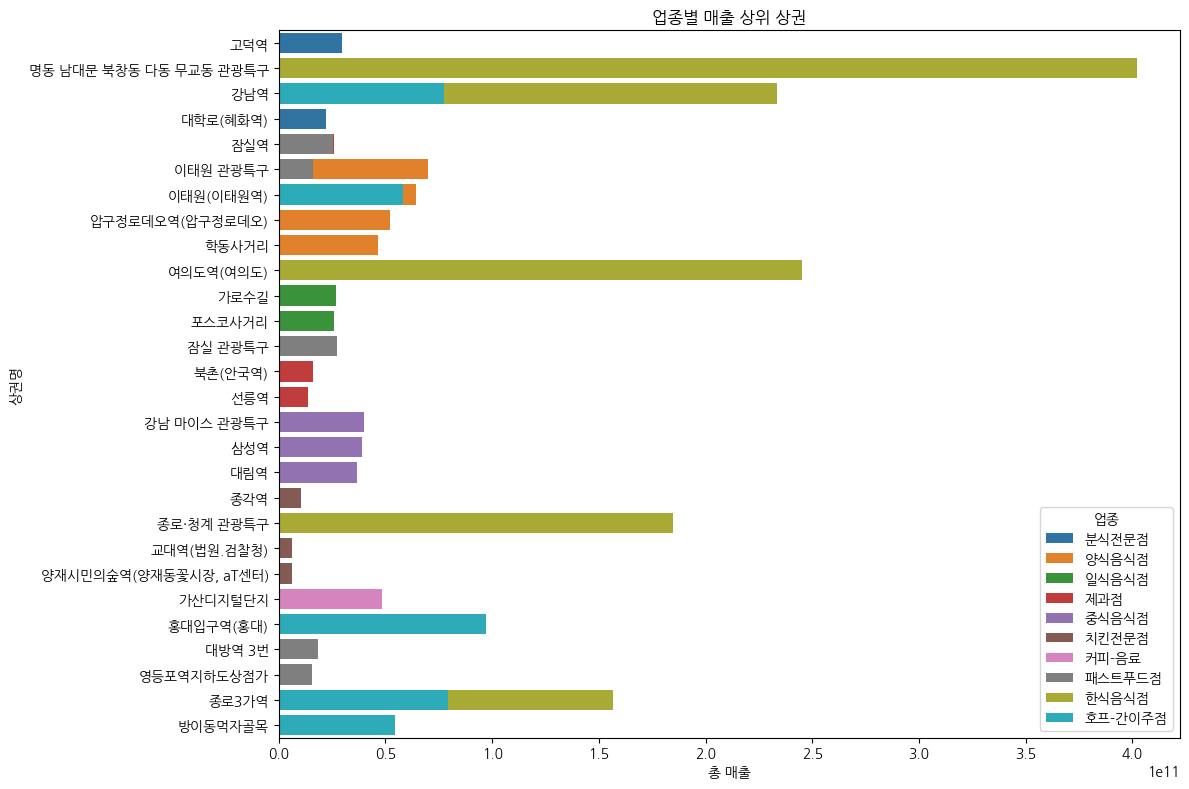

In [ ]:
import koreanize_matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 5
df_top = df.groupby('service_category_name', group_keys=False).apply(lambda x: x.nlargest(top_n, 'total_sales'))

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top,
    x='total_sales',
    y='commercial_area_name',
    hue='service_category_name',
    dodge=False
)

plt.title('업종별 매출 상위 상권')
plt.xlabel('총 매출')
plt.ylabel('상권명')
plt.legend(title='업종')
plt.tight_layout()
plt.show()


/tmp/ipykernel_13254/393529050.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('total_sales', ascending=False).head(top_n))


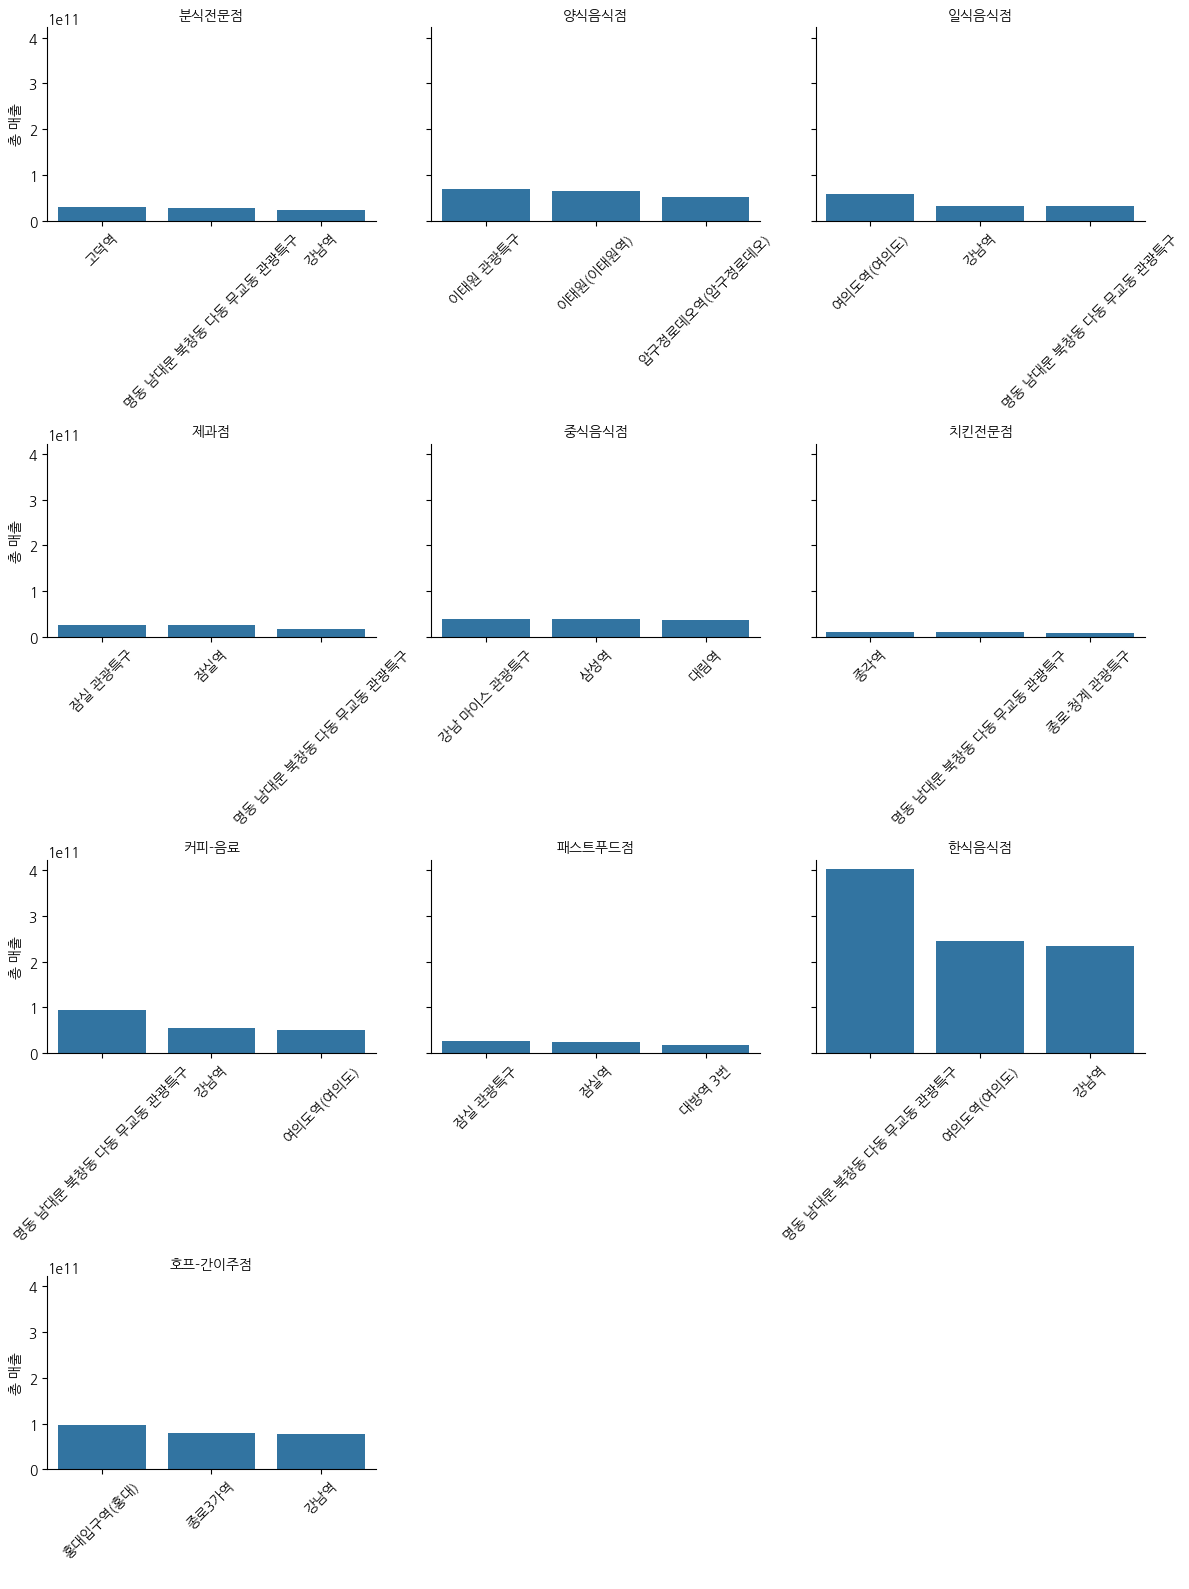

In [ ]:
import koreanize_matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 3

df_top = (
    df.groupby('service_category_name', group_keys=False)
      .apply(lambda x: x.sort_values('total_sales', ascending=False).head(top_n))
)

g = sns.FacetGrid(df_top, col='service_category_name', col_wrap=3, height=4, sharex=False)

def barplot_facet(data, **kwargs):
    data = data.sort_values('total_sales', ascending=False)
    sns.barplot(
        x='commercial_area_name',
        y='total_sales',
        data=data,
        **kwargs
    )
    plt.xticks(rotation=45)

g.map_dataframe(barplot_facet)
g.set_titles('{col_name}')
g.set_axis_labels(' ', '총 매출')
plt.tight_layout()
plt.show()


In [18]:
df_top.head()

,commercial_area_code,commercial_area_name,service_category_name,total_sales
174,3120249,고덕역,분식전문점,2.970573e+10
200,3001492,명동 남대문 북창동 다동 무교동 관광특구,분식전문점,2.704672e+10
244,3120189,강남역,분식전문점,2.331839e+10
40,3001491,이태원 관광특구,양식음식점,6.998784e+10
44,3120046,이태원(이태원역),양식음식점,6.452400e+10
